In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
from numpy.linalg import svd, norm, pinv
import scipy.sparse.linalg as sp
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import codecs
import pickle
from wordcloud import WordCloud
from PIL import Image
%matplotlib inline

In [2]:
# load data
with open('train.json') as data_file:    
    dataList = json.load(data_file)

# create list (with duplicates) of ingredients and list of lists in form [recipe ID, cuisine type]
nrec = len(dataList)
print "total recipies in dataList: %d" % (nrec)
cuisList = []
ingListRaw = []
# nrow = 10
for row in dataList: 
    cuisList.append([row['id'], row['cuisine']])
    ingListRaw += row['ingredients']
print 'done'

#look at cuisines
cuis_setList=[]
cuisineDict = {}
for cuis in cuisList:
  cuis_setList.append(cuis[1])
cuis_setList = sorted(list(set(cuis_setList)))
print "there are %d cuisines " % (len(cuis_setList))
print cuis_setList

# remove duplicate copies of ingredients to get unique list of ingredients
ingListRaw = list(set(ingListRaw))
num_ing = len(ingListRaw)
print "there are %d ingredients in unique ingListRaw" % (num_ing) #len(ingListRaw[0:]))

print 'done'

total recipies in dataList: 39774
done
there are 20 cuisines 
[u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino', u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican', u'japanese', u'korean', u'mexican', u'moroccan', u'russian', u'southern_us', u'spanish', u'thai', u'vietnamese']
there are 6714 ingredients in unique ingListRaw
done


In [3]:
def create_dicts(dataList, ingListRaw, write = False):
    # create cuisine Dictionary where key = recipe ID and value = cuisine type
    cuisineDict = {}
    for row in dataList:
        cuisineDict[row['id']]= row['cuisine']
    print len(cuisineDict)

    if write:
        file_out = open('cuisineDict.pck', 'wb')
        pickle.dump(cuisineDict, file_out)
        file_out.close()

    #create ingredients dictionary where key = ingredient and value = column index
    #and reverse dictionary where key = column index and value = ingredient
    ingDict = {}
    colToIngDict = {}
    ct=0
    for ing in ingListRaw:
        if not ing in ingDict.keys():
            ct += 1
            ingDict[ing] = ct
            colToIngDict[ct-1] = ing

    if write:
        file_out = open('ingDict.pck', 'wb')
        pickle.dump(ingDict, file_out)
        file_out.close()

    # create id dictionary where key = recipe ID and value = row index
    # and reverse dictionary where key = row index and value = recipe ID
    idDict={}
    rowToRecDict = {}
    ct = 0
    for row in dataList:
        idDict[row['id']] = ct
        rowToRecDict[ct] = row['id']
        ct += 1

    # check key value pairs
    print idDict[45887], idDict.keys()[idDict.values().index(11)]  
    
    if write:
        file_out = open('idDict.pck', 'wb')
        pickle.dump(idDict, file_out)
        file_out.close()
        
    return cuisineDict, ingDict, colToIngDict, idDict, rowToRecDict

cuisineDict, ingDict, colToIngDict, idDict, rowToRecDict = create_dicts(dataList, ingListRaw, write = True)

39774
11 45887


In [4]:
# create master array: Araw[i, j] = 1 if ingredient j is in recipe i
# note: first column of Araw is recipe ID (will be removed when running classification)
nrow = nrec
ncol = num_ing+1
Araw = np.zeros((nrow,ncol))

for row in dataList:
    recipe_idx = idDict[row['id']]
    Araw[recipe_idx,0]= row['id']
    for ing in row['ingredients']:
        ing_idx = ingDict[ing]
        Araw[recipe_idx,ing_idx] = 1
        
print 'done'

done


In [5]:
# Clean and normalize data
def trim_rows(A1, rowToRecDict, min_ct_rec = 4, max_ct_rec = 10000):
    recCtArr = np.sum(A1, axis = 1)
    recCtArrSort = np.sort(recCtArr)

    recIds = (recCtArr > min_ct_rec) & (recCtArr < max_ct_rec)

    recList = []
    for idx in sorted(rowToRecDict.keys()):
        if recIds[idx] == 1:
            recList.append(rowToRecDict[idx])  
    A2 = A1[recIds, :]
    return A2, recList

def trim_cols(A1, colToIngDict, min_ct = 10, max_ct = 1000000):
    ingCtArr = np.sum(A1, axis = 0)
    ingCtArrSort = np.sort(ingCtArr)

    min_ct = 10; max_ct = 1000000
    ingIds = (ingCtArr > min_ct) & (ingCtArr < max_ct)

    ingList = []
    for idx in sorted(colToIngDict.keys()):
        if ingIds[idx] == 1:
            ingList.append(colToIngDict[idx])

    A2 = A1[:, ingIds]
    return A2, ingList

def normalize(A):
    return (A - np.mean(A, axis = 0))/np.std(A, axis = 0)

A1 = Araw[:, 1:]
A2, recList = trim_rows(A1, rowToRecDict) # remove recipes that have too few ingredients 
A3, ingList = trim_cols(A2, colToIngDict, max_ct = 200) # remove ingredients that appear in too few or too many recipes
M = normalize(A3) # normalize by subtracting mean and dividing by standard deviation for each column

print A1.shape
print M.shape
print np.mean(M, axis = 0)
print np.std(M, axis = 0)

(39774L, 6714L)
(37882L, 2245L)
[ -9.37836883e-18  -2.81351065e-18  -9.00323407e-18 ...,   1.14416100e-17
   7.87782981e-18  -3.84513122e-18]
[ 1.  1.  1. ...,  1.  1.  1.]


In [6]:
# Perform PCA dimensionality reduction, choose k = 50 components to keep
# so we reduce dimensionality from 2245 ingredients to 50 principal components

Uraw, Sraw, Vraw = sp.svds(M, k = 50)
sArr = Sraw[::-1] # this svd routine returns the components in the reverse order
V = Vraw[::-1, :] # this svd routine returns the components in the reverse order
U = Uraw[:, ::-1] # this svd routine returns the components in the reverse order
# plt.plot(sArr, '-')

Mred = M.dot(V.T) # Mred stores the final, reduced dataset that we'll work with to classify recipes

print M.shape
print V.T.shape
print Mred.shape
print 'done'

(37882L, 2245L)
(2245L, 50L)
(37882L, 50L)
done


In [7]:
# build solution vector - array with cuisine idx for each recipe
cuisIdDict = {}
ct = 0
for cuis in cuis_setList:
    cuisIdDict[cuis] = ct
    ct += 1

print cuisIdDict
y = np.zeros(len(recList), dtype = int)
yArr = np.zeros((len(recList), len(cuisIdDict)))
row_idx = 0
for row_idx, rec_id in enumerate(recList):
    cuis_idx = cuisIdDict[cuisineDict[rec_id]]
    y[row_idx] = cuis_idx
    yArr[row_idx, cuis_idx] = 1

print 'done'

{u'irish': 8, u'mexican': 13, u'chinese': 3, u'filipino': 4, u'vietnamese': 19, u'moroccan': 14, u'spanish': 17, u'japanese': 11, u'french': 5, u'greek': 6, u'indian': 7, u'cajun_creole': 2, u'british': 1, u'brazilian': 0, u'russian': 15, u'jamaican': 10, u'korean': 12, u'southern_us': 16, u'thai': 18, u'italian': 9}
done


In [8]:
# this routine splits the full dataset into two parts: a training and a test set
def get_train_test(H, y, split = 'half'):
    if split == 'half':
        row_cut = int(H.shape[0]*(1.0/2.0))
    else:
        row_cut = int(Mred.shape[0]*(4.0/5.0))
        
    Htrain = H[:row_cut]
    Htest = H[row_cut:]
    ytrain = y[:row_cut]
    ytest = y[row_cut:]
    return Htrain, ytrain, Htest, ytest

Mtrain, ytrain, Mtest, ytest = get_train_test(Mred, y)
print 'done'

done


# SVM Classifier

In [9]:
from sklearn import svm
import time

t1 = time.time()
clf = svm.SVC() # construct a support vector classifier object (since there are no keywords provided, the default option
# of using radial basis function kernel is used)
clf.fit(Mtrain, ytrain) # train the SVC on our data - recipes in Mtrain with labels in ytrain
t2 = time.time()
print 'time = %.1f' % (t2 - t1) # print out how much time this took
print 'done'

time = 34.7
done


In [10]:
# num_test = 1000

def get_error(Minraw, yinraw, num_test):
    Min = Minraw[:num_test] # take only num_test recipes to test accuracy on
    yin = yinraw[:num_test]
    y = clf.predict(Min[:num_test]) # predicted labels for these input recipes
    errArr = np.zeros(num_test) 
    errArr[y != yin[:num_test]] = 1 # construct an array errArr that has a 1 in all 
    # the indices in which the predicted labels don't match the ground truth (yin)
    err_train = (np.sum(errArr)/num_test)*100.0 # compute the percent of recipes misclassified
    return err_train

err_train = get_error(Mtrain, ytrain, num_test = Mtrain.shape[0])
err_test = get_error(Mtest, ytest, num_test = Mtest.shape[0])
print 'training accuracy  = %.2f' % (100.0 - err_train)
print 'validation accuracy = %.2f' % (100.0 - err_test)

training accuracy  = 86.75
validation accuracy = 74.17


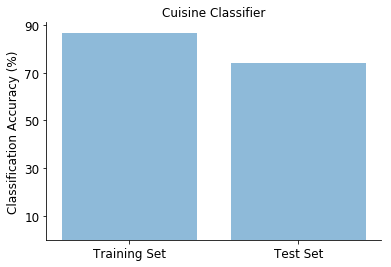

In [11]:
# plot a bargraph showing accuracy on training and test sets
fig, ax = plt.subplots(1)

objects = ('Training Set', 'Test Set')
y_pos = np.arange(len(objects))
performance = [100.0 - err_train, 100.0 - err_test]


fs = 12
ax.bar(y_pos, performance, align='center', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(y_pos, objects, fontsize = fs)
plt.yticks(np.arange(10, 100, 20), fontsize = fs)
plt.ylabel('Classification Accuracy (%)', fontsize = fs)
plt.title('Cuisine Classifier', fontsize = fs)